In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

from tensorflow.keras import utils as np_utils

from random import shuffle
from tensorflow.python.client import device_lib

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For wider plots
plt.rcParams["figure.figsize"] = (20,6)

os.environ['TF_XLA_FLAGS']="--tf_xla_enable_xla_devices"
# Take my NVidia GPU into use
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

2023-05-04 13:21:37.005436: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-162dnswu because the default path (/home/harsh/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
from tensorflow.python.client import device_lib 
os.environ['TF_XLA_FLAGS']="--tf_xla_enable_xla_devices"
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9498133054652539624
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10105426490035143022
physical_device_desc: "device: XLA_CPU device"
]


2023-05-04 13:21:39.961270: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 13:21:39.988452: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz
2023-05-04 13:21:39.991387: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1b12f60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-05-04 13:21:39.991426: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-05-04 13:21:39.995836: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-05-04 13:21:40.059864: E tensorflow/stream_executor/c

In [3]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [4]:
files1 = glob.glob("./parkinsons/*Si**Co*.txt")
files2 = glob.glob("./parkinsons/*Si**Pt*.txt")
files1j = glob.glob("./parkinsons/*Ju**Co*.txt")
files2j = glob.glob("./parkinsons/*Ju**Pt*.txt")
files1s = glob.glob("./parkinsons/*Ga**Co*.txt")
files2s = glob.glob("./parkinsons/*Ga**Pt*.txt")
# files=files1+files2
# shuffle(files)

In [5]:
print(len(files1))
print(len(files2))     
print(len(files1j))
print(len(files2j))     
print(len(files1s))
print(len(files2s))     

29
35
25
104
38
75


In [6]:
columns = ["elaps_time","L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]

In [7]:
def getClassForHealthyOrNot(filename):
    if (filename.find("Co") >=0):
        return 0
    else:
        return 1


In [8]:
class Patient:
    def __init__(self,input_data,y):
        self.x = input_data
        self.y = y
        self.x_scaled = input_data

In [9]:
patients=[]
un_used_data=[]

for f in files1:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients.append( Patient(data, ispark) )
        
        j=j+75

In [10]:
patients1=[]
un_used_data1=[]

for f in files2:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients1.append( Patient(data, ispark) )
        
        j=j+75

In [11]:
len(patients)

4640

In [12]:
len(patients1)


5600

In [13]:
shuffle(patients)
shuffle(patients1)

In [14]:
train = patients[:int(len(patients)*0.8)]+patients1[:int(len(patients1)*0.8)]
test = patients[int(len(patients)*0.8):]+patients1[int(len(patients1)*0.8):]

In [15]:
print(len(train))
print(len(test))

8192
2048


In [16]:
shuffle(train)
shuffle(test)

In [17]:
train_concat=[]
for p in train:
    train_concat = train_concat+[p.x]

In [18]:
data_tr = pd.concat(train_concat,ignore_index=True)

In [19]:
scaler = StandardScaler()
scaler.fit_transform(data_tr)

array([[ 0.61430115,  2.03167419,  2.97482669, ..., -0.70755311,
         1.36637122, -1.12792193],
       [ 0.51611631,  1.89239789,  2.83049039, ..., -0.70755311,
         1.28622239, -1.12792193],
       [ 0.41361567,  1.7543019 ,  2.62945054, ..., -0.70755311,
         1.1869134 , -1.12792193],
       ...,
       [ 0.2690358 ,  0.52442137,  1.72348251, ...,  2.15783319,
         0.18950574, -0.26214549],
       [ 0.24961463,  0.49019245,  1.70157432, ...,  2.12059351,
         0.21838091, -0.37872368],
       [ 0.23019345,  0.49019245,  1.67966613, ...,  1.86405351,
         0.25481219, -0.51812836]])

In [20]:
i=0
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in train:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [21]:
for obj in test:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1

In [22]:
X_scaled_list_train=[]
Y_list_train=[]

for obj in train:
    X_scaled_list_train = X_scaled_list_train + [obj.x_scaled]
    Y_list_train = Y_list_train + [obj.y]
    
X_scaled_arr_train = np.array(X_scaled_list_train)
Y_arr_train = np.array(Y_list_train)

In [23]:
X_scaled_arr_train.shape

(8192, 150, 18)

In [24]:
Y_arr_train.shape

(8192,)

In [25]:
X_scaled_list_test=[]
Y_list_test=[]

for obj in test:
    X_scaled_list_test = X_scaled_list_test + [obj.x_scaled]
    Y_list_test = Y_list_test + [obj.y]
    
X_scaled_arr_test = np.array(X_scaled_list_test)
Y_arr_test = np.array(Y_list_test)

In [26]:
import numpy as np

In [27]:
model = Sequential()
model.add(Bidirectional(LSTM(80, dropout=0.3, 
                  return_sequences=True, 
                  input_shape=(X_scaled_arr_train.shape[1], X_scaled_arr_train.shape[2]))))
model.add(Bidirectional(LSTM(32, dropout=0.5,return_sequences=True)))
model.add(LSTM(24, dropout=0.2,return_sequences=True))
model.add(LSTM(12, dropout=0.2,return_sequences=False))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='relu'))
opt=tf.keras.optimizers.Adam(
    learning_rate=0.0001,
    name="Adam"
    )
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10|0, verbose=1, mode='auto')
checkpoint = ModelCheckpoint("./Model/model_LSTM22_150_cross_test.v", 
                             monitor='val_accuracy', verbose=1, save_best_only=True, 
                             save_weights_only=False)

In [28]:
history = model.fit(X_scaled_arr_train,Y_arr_train,epochs=500,validation_split=0.2,batch_size=20,shuffle=True,callbacks=[early_stopping, checkpoint])

2023-05-04 13:22:31.631479: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/500
328/328 [==============================] - 173s 494ms/step - loss: 3.1158 - accuracy: 0.4782 - val_loss: 0.6329 - val_accuracy: 0.6467

Epoch 00001: val_accuracy improved from -inf to 0.64674, saving model to ./Model/model_LSTM22_150_cross_test.v


2023-05-04 13:25:45.045518: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 2/500
328/328 [==============================] - 154s 468ms/step - loss: 0.6095 - accuracy: 0.6786 - val_loss: 0.5830 - val_accuracy: 0.7169

Epoch 00002: val_accuracy improved from 0.64674 to 0.71690, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 3/500
328/328 [==============================] - 152s 465ms/step - loss: 0.5666 - accuracy: 0.7147 - val_loss: 0.5766 - val_accuracy: 0.7621

Epoch 00003: val_accuracy improved from 0.71690 to 0.76205, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 4/500
328/328 [==============================] - 153s 466ms/step - loss: 0.5612 - accuracy: 0.7298 - val_loss: 0.5943 - val_accuracy: 0.6797

Epoch 00004: val_accuracy did not improve from 0.76205
Epoch 5/500
328/328 [==============================] - 153s 468ms/step - loss: 0.5693 - accuracy: 0.7030 - val_loss: 0.5470 - val_accuracy: 0.7138

Epoch 00005: val_accuracy did not improve from 0.76205
Epoch 6/500
328/328 [==============================] - 153s 465ms/step - loss: 0.5347 - accuracy: 0.7380 - val_loss: 0.5059 - val_accuracy: 0.7511

Epoch 00006: val_accuracy did not improve from 0.76205
Epoch 7/500
328/328 [==============================] - 154s 470ms/step - loss: 0.4976 - accuracy: 0.7618 - val_loss: 0.4993 - val_accuracy: 0.7749

Epoch 00007: val_accuracy improved from 0.76205 to 0.77486, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 8/500
328/328 [==============================] - 152s 465ms/step - loss: 0.4677 - accuracy: 0.7774 - val_loss: 0.4310 - val_accuracy: 0.8048

Epoch 00008: val_accuracy improved from 0.77486 to 0.80476, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 9/500
328/328 [==============================] - 151s 461ms/step - loss: 0.4490 - accuracy: 0.7924 - val_loss: 0.4331 - val_accuracy: 0.8157

Epoch 00009: val_accuracy improved from 0.80476 to 0.81574, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 10/500
328/328 [==============================] - 150s 459ms/step - loss: 0.4396 - accuracy: 0.8154 - val_loss: 0.4921 - val_accuracy: 0.7206

Epoch 00010: val_accuracy did not improve from 0.81574
Epoch 11/500
328/328 [==============================] - 149s 456ms/step - loss: 0.4774 - accuracy: 0.7710 - val_loss: 0.4254 - val_accuracy: 0.8139

Epoch 00011: val_accuracy did not improve from 0.81574
Epoch 12/500
328/328 [==============================] - 150s 458ms/step - loss: 0.5406 - accuracy: 0.7480 - val_loss: 0.4854 - val_accuracy: 0.7657

Epoch 00012: val_accuracy did not improve from 0.81574
Epoch 13/500
328/328 [==============================] - 152s 464ms/step - loss: 0.4938 - accuracy: 0.7774 - val_loss: 0.4352 - val_accuracy: 0.8212

Epoch 00013: val_accuracy improved from 0.81574 to 0.82123, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 14/500
328/328 [==============================] - 150s 456ms/step - loss: 0.4344 - accuracy: 0.8134 - val_loss: 0.4535 - val_accuracy: 0.8017

Epoch 00014: val_accuracy did not improve from 0.82123
Epoch 15/500
328/328 [==============================] - 151s 460ms/step - loss: 0.4536 - accuracy: 0.8055 - val_loss: 0.3851 - val_accuracy: 0.8505

Epoch 00015: val_accuracy improved from 0.82123 to 0.85052, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 16/500
328/328 [==============================] - 158s 483ms/step - loss: 0.3915 - accuracy: 0.8477 - val_loss: 0.3537 - val_accuracy: 0.8725

Epoch 00016: val_accuracy improved from 0.85052 to 0.87248, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 17/500
328/328 [==============================] - 152s 464ms/step - loss: 0.3551 - accuracy: 0.8611 - val_loss: 0.3599 - val_accuracy: 0.8877

Epoch 00017: val_accuracy improved from 0.87248 to 0.88774, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 18/500
328/328 [==============================] - 150s 459ms/step - loss: 0.3382 - accuracy: 0.8718 - val_loss: 0.2876 - val_accuracy: 0.9067

Epoch 00018: val_accuracy improved from 0.88774 to 0.90665, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 19/500
328/328 [==============================] - 147s 449ms/step - loss: 0.3650 - accuracy: 0.8732 - val_loss: 0.2410 - val_accuracy: 0.9158

Epoch 00019: val_accuracy improved from 0.90665 to 0.91580, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 20/500
328/328 [==============================] - 151s 461ms/step - loss: 0.2637 - accuracy: 0.9118 - val_loss: 0.2447 - val_accuracy: 0.9353

Epoch 00020: val_accuracy improved from 0.91580 to 0.93533, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 21/500
328/328 [==============================] - 151s 461ms/step - loss: 0.3043 - accuracy: 0.9005 - val_loss: 0.1861 - val_accuracy: 0.9481

Epoch 00021: val_accuracy improved from 0.93533 to 0.94814, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 22/500
328/328 [==============================] - 149s 455ms/step - loss: 0.4542 - accuracy: 0.8607 - val_loss: 0.1923 - val_accuracy: 0.9433

Epoch 00022: val_accuracy did not improve from 0.94814
Epoch 23/500
328/328 [==============================] - 152s 463ms/step - loss: 0.2457 - accuracy: 0.9243 - val_loss: 0.1777 - val_accuracy: 0.9524

Epoch 00023: val_accuracy improved from 0.94814 to 0.95241, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 24/500
328/328 [==============================] - 150s 458ms/step - loss: 0.2201 - accuracy: 0.9355 - val_loss: 0.1593 - val_accuracy: 0.9591

Epoch 00024: val_accuracy improved from 0.95241 to 0.95912, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 25/500
328/328 [==============================] - 150s 457ms/step - loss: 0.2162 - accuracy: 0.9352 - val_loss: 0.1165 - val_accuracy: 0.9744

Epoch 00025: val_accuracy improved from 0.95912 to 0.97437, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 26/500
328/328 [==============================] - 151s 459ms/step - loss: 0.2860 - accuracy: 0.9162 - val_loss: 0.1606 - val_accuracy: 0.9536

Epoch 00026: val_accuracy did not improve from 0.97437
Epoch 27/500
328/328 [==============================] - 150s 458ms/step - loss: 0.1938 - accuracy: 0.9398 - val_loss: 0.2239 - val_accuracy: 0.9457

Epoch 00027: val_accuracy did not improve from 0.97437
Epoch 28/500
328/328 [==============================] - 151s 460ms/step - loss: 0.2027 - accuracy: 0.9376 - val_loss: 0.2449 - val_accuracy: 0.9433

Epoch 00028: val_accuracy did not improve from 0.97437
Epoch 29/500
328/328 [==============================] - 151s 459ms/step - loss: 0.1748 - accuracy: 0.9511 - val_loss: 0.1238 - val_accuracy: 0.9701

Epoch 00029: val_accuracy did not improve from 0.97437
Epoch 30/500
328/328 [==============================] - 152s 463ms/step - loss: 0.1437 - accuracy: 0.9595 - val_loss: 0.0946 - val_accuracy: 0.9817

Epoch 00030: val_accuracy improved 

INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 31/500
328/328 [==============================] - 149s 454ms/step - loss: 0.1243 - accuracy: 0.9735 - val_loss: 0.0869 - val_accuracy: 0.9829

Epoch 00031: val_accuracy improved from 0.98170 to 0.98292, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 32/500
328/328 [==============================] - 151s 462ms/step - loss: 0.1238 - accuracy: 0.9740 - val_loss: 0.0661 - val_accuracy: 0.9860

Epoch 00032: val_accuracy improved from 0.98292 to 0.98597, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 33/500
328/328 [==============================] - 150s 457ms/step - loss: 0.1140 - accuracy: 0.9702 - val_loss: 0.0856 - val_accuracy: 0.9841

Epoch 00033: val_accuracy did not improve from 0.98597
Epoch 34/500
328/328 [==============================] - 148s 452ms/step - loss: 0.2686 - accuracy: 0.9423 - val_loss: 0.0716 - val_accuracy: 0.9847

Epoch 00034: val_accuracy did not improve from 0.98597
Epoch 35/500
328/328 [==============================] - 151s 462ms/step - loss: 0.1616 - accuracy: 0.9703 - val_loss: 0.0695 - val_accuracy: 0.9841

Epoch 00035: val_accuracy did not improve from 0.98597
Epoch 36/500
328/328 [==============================] - 150s 456ms/step - loss: 0.1160 - accuracy: 0.9752 - val_loss: 0.0494 - val_accuracy: 0.9908

Epoch 00036: val_accuracy improved from 0.98597 to 0.99085, saving model to ./Model/model_LSTM22_150_cross_test.v


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


INFO:tensorflow:Assets written to: ./Model/model_LSTM22_150_cross_test.v/assets


Epoch 37/500
328/328 [==============================] - 151s 461ms/step - loss: 0.1126 - accuracy: 0.9764 - val_loss: 0.1312 - val_accuracy: 0.9817

Epoch 00037: val_accuracy did not improve from 0.99085
Epoch 38/500
328/328 [==============================] - 149s 454ms/step - loss: 0.1487 - accuracy: 0.9713 - val_loss: 0.3681 - val_accuracy: 0.9109

Epoch 00038: val_accuracy did not improve from 0.99085
Epoch 39/500
328/328 [==============================] - 150s 457ms/step - loss: 0.4140 - accuracy: 0.8153 - val_loss: 0.3884 - val_accuracy: 0.8231

Epoch 00039: val_accuracy did not improve from 0.99085
Epoch 40/500
328/328 [==============================] - 148s 451ms/step - loss: 0.3420 - accuracy: 0.8686 - val_loss: 0.1960 - val_accuracy: 0.9250

Epoch 00040: val_accuracy did not improve from 0.99085
Epoch 41/500
328/328 [==============================] - 150s 459ms/step - loss: 0.1893 - accuracy: 0.9412 - val_loss: 0.1002 - val_accuracy: 0.9701

Epoch 00041: val_accuracy did not i

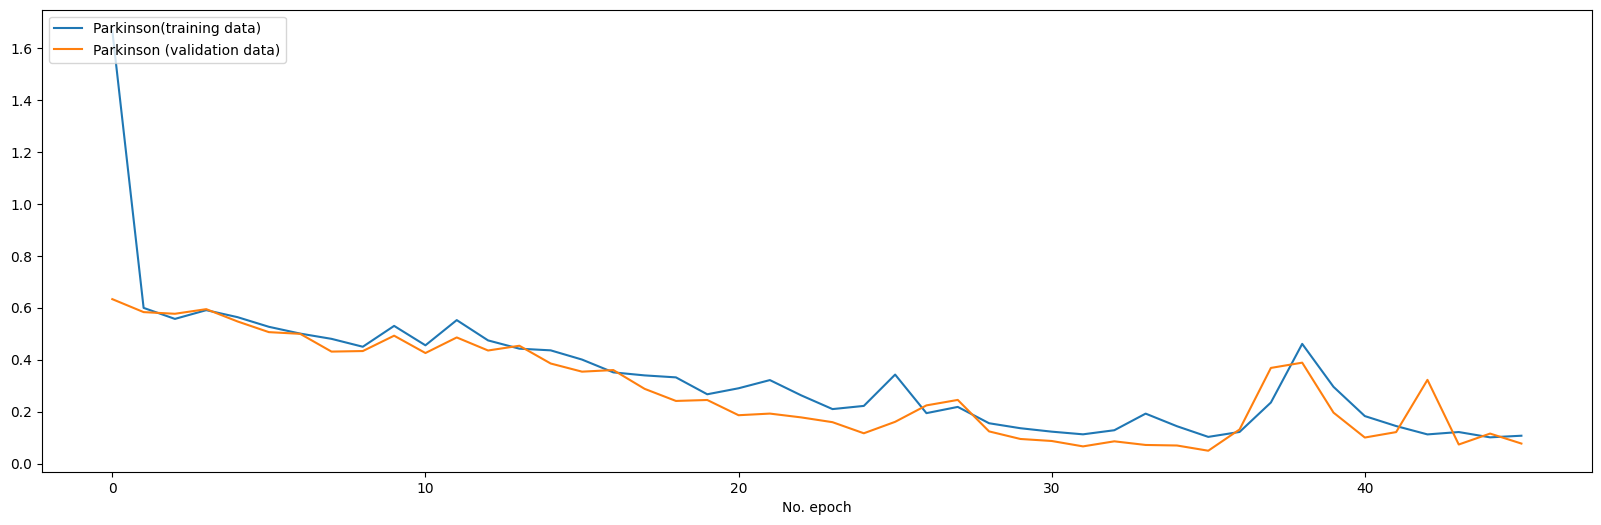

In [41]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

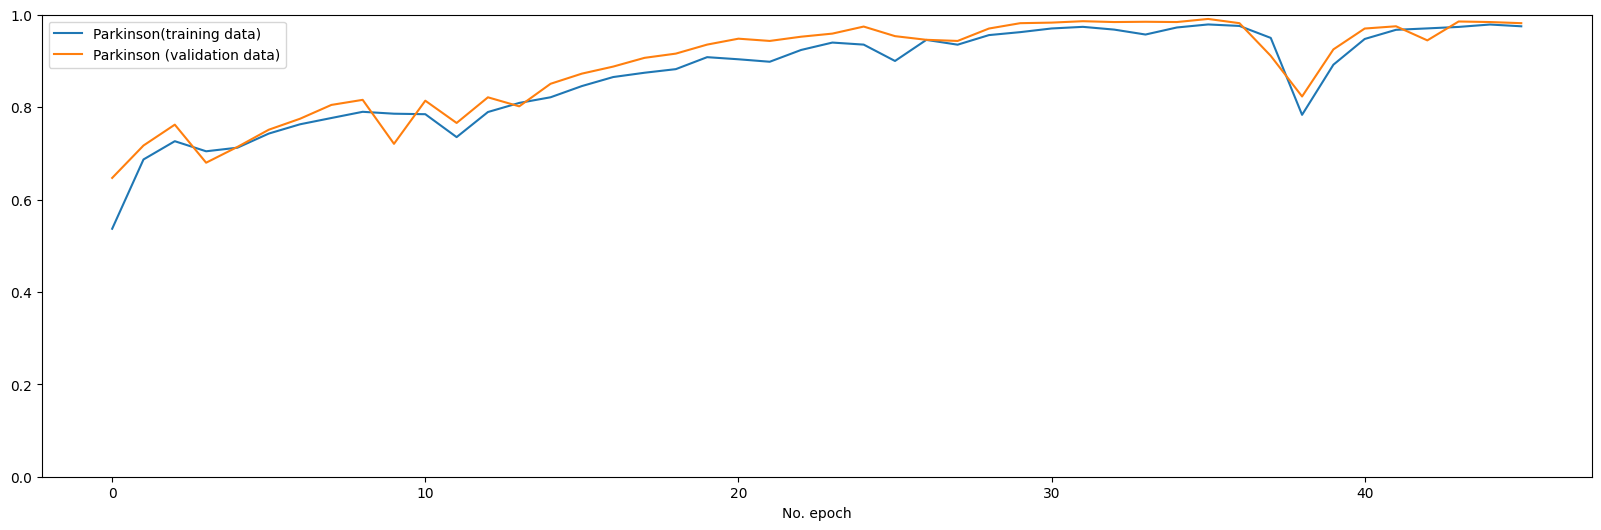

In [42]:
plt.plot(history.history['accuracy'], label='Parkinson(training data)')
plt.plot(history.history['val_accuracy'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.ylim(0,1)
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

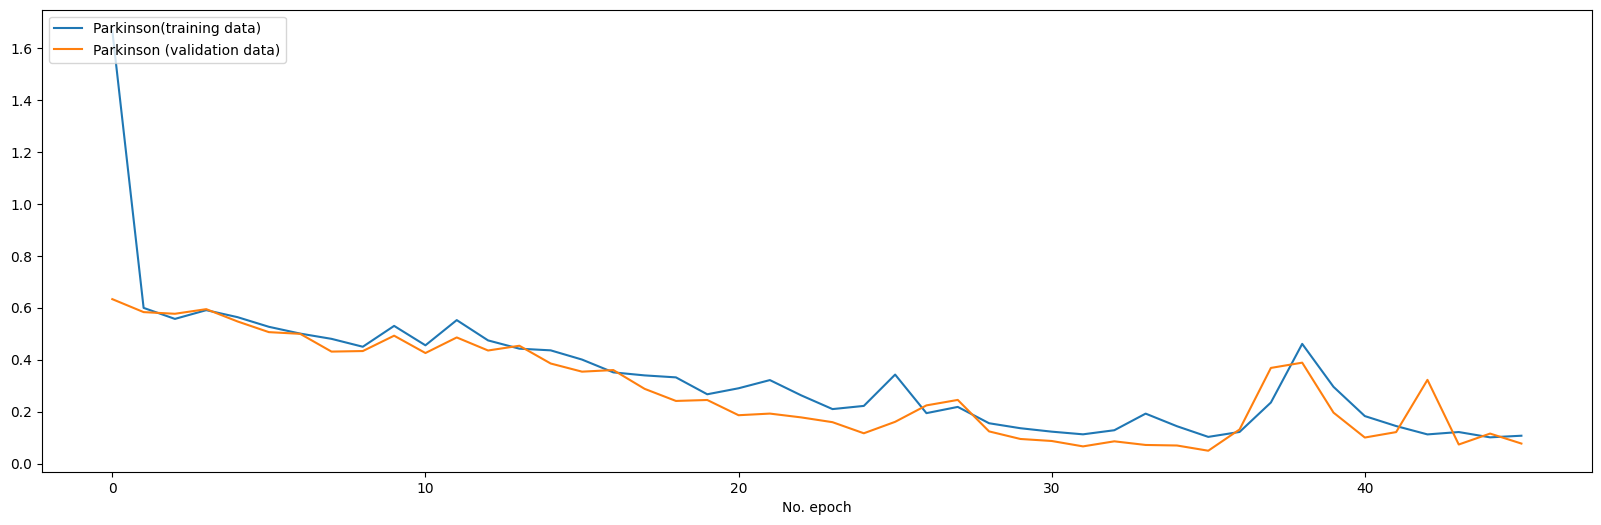

In [43]:
plt.plot(history.history['loss'], label='Parkinson(training data)')
plt.plot(history.history['val_loss'], label='Parkinson (validation data)')
plt.title('')
plt.ylabel('')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [32]:
pdt1=model.predict(X_scaled_arr_test)
pdt1.size
classes_x1 = np.zeros((len(pdt1)))
for x in range(len(pdt1)):
  if(pdt1[x]>0.5):
    classes_x1[x]=(1)
  else:
    classes_x1[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(Y_arr_test,classes_x1 )

In [33]:
accuracy

0.9765625

In [45]:
patients_t=[]
un_used_data_t=[]

for f in files1s:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients_t.append( Patient(data, ispark) )
        
        j=j+75

In [46]:
patients1_t=[]
un_used_data1_t=[]

for f in files2s:
    #print(f"{i+1}. {file}")
    
    data_txt = pd.read_table(f,names=columns)
    data_txt.drop(['elaps_time'],inplace=True,axis=1)
    
    
    
    j=0
    ispark = getClassForHealthyOrNot(f)
    # print(ispark)
    while j < 12001:
        data = data_txt.iloc[j+1:j+151,:]
        
        if data.shape[0] == 150:
            patients1_t.append( Patient(data, ispark) )
        
        j=j+75

In [47]:
len(patients_t)

5972

In [48]:
test_t= patients+patients1_t

In [49]:
wo_time_col=["L1", "L2","L3","L4","L5","L6","L7","L8","R1","R2","R3","R4","R5","R6","R7","R8","LTot","RTot"]
for obj in test_t:
    obj.x_scaled = pd.DataFrame(scaler.transform(obj.x),columns=wo_time_col)
    i=i+1
    
X_scaled_list_test_t=[]
Y_list_test_t=[]

for obj in test_t:
    X_scaled_list_test_t = X_scaled_list_test_t + [obj.x_scaled]
    Y_list_test_t = Y_list_test_t + [obj.y]
    
X_scaled_arr_test_t = np.array(X_scaled_list_test_t)
Y_arr_test_t = np.array(Y_list_test_t)

In [50]:
pdt1_t=model.predict(X_scaled_arr_test_t)
pdt1_t.size
classes_x1_t = np.zeros((len(pdt1_t)))
for x in range(len(pdt1_t)):
  if(pdt1_t[x]>0.5):
    classes_x1_t[x]=(1)
  else:
    classes_x1_t[x]=(0)
#   print(x,end=" ")
from sklearn.metrics import accuracy_score
accuracy_t = accuracy_score(Y_arr_test_t,classes_x1_t )

In [40]:
accuracy_t ##For Ju

0.6445761494252874

In [51]:
accuracy_t

0.7761418269230769